#### <img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data Visualization</center>

# Worksheet S4: Prophet

## Caso práctico: Predicción sobre el número de visitas que recibe la entrada de Wikipedia de Peyton Manning

## 0. Objetivo

El objetivo de este worksheet es conocer y utilizar **Prophet**, una librería de Data Science que fue liberada por Facebook el 23 de Febrero de 2017 para **el análisis y la predicción de series temporales**. Para ello, vamos a utilizar el siguiente caso práctico:



<img src="peyton.jpg" style="float:right; height: 250px"></img>
Queremos **prever el número de personas** que visitan la página de Wikipedia de Peyton Manning (una de las grandes figuras del fútbol americano): 

https://en.wikipedia.org/wiki/Peyton_Manning

Vamos a realizar una **predicción para un año** completo.

Como veremos durante el desarrollo del Worksheet, este ejemplo ilustra algunas de las principales características de Prophet, como la estacionalidad múltiple, las tasas de crecimiento cambiantes y la capacidad de modelar días especiales.

### Instalación de Prophet 

Para poder utilizar Prophet deberemos instalar primero la librería y sus dependencias. La forma más fácil es teniendo instalado Anaconda y ejecutando el siguiente comando desde el terminal:

** conda install -c conda-forge fbprophet** 

## 1. Preparar el contexto

Lo primero de todo es importar las librerías que vamos a utilizar en nuestro Worksheet.

In [33]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

## 2.Obtención de los datos

Como en otros casos, utilizamos la función *read_csv* que nos proporciona la librería de Pandas y que nos facilita la lectura de ficheros.

In [34]:
df_datos = pd.read_csv('example_wp_peyton_manning.csv')

Comprobamos **qué hemos cargado**. Utilizando las funciones *info(), describe()* y *head()* podemos hacer un primer análisis de los datos cargados. Veamos que contiene nuestro dataset de partida:

In [35]:
df_datos.tail()

,fecha,visitas
2900,2016-01-16,2483
2901,2016-01-17,10656
2902,2016-01-18,30754
2903,2016-01-19,9190
2904,2016-01-20,7269


In [36]:
df_datos.describe()

,visitas
count,2905.000000
mean,5794.732186
std,13864.136069
min,193.000000
25%,1835.000000
50%,2975.000000
75%,5325.000000
max,379552.000000


In [37]:
df_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fecha    2905 non-null   object
 1   visitas  2905 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.5+ KB


** P: ¿Qué hemos cargado?**

Hemos cargado una **serie temporal**, que incluye el **número de visitas** que se realizan a la página de la Wikipedia de Peyton Manning **por día**, desde diciembre de 2007 a enero de 2016.

### 2.1.- Interpretación de nuestros datos

Antes de comenzar a utilizar la librería de Prophet para realizar nuestra predicción, vamos a analizar un poco más los datos que tenemos de partida.

** P: ¿Qué componentes de una serie temporal tiene? ** 

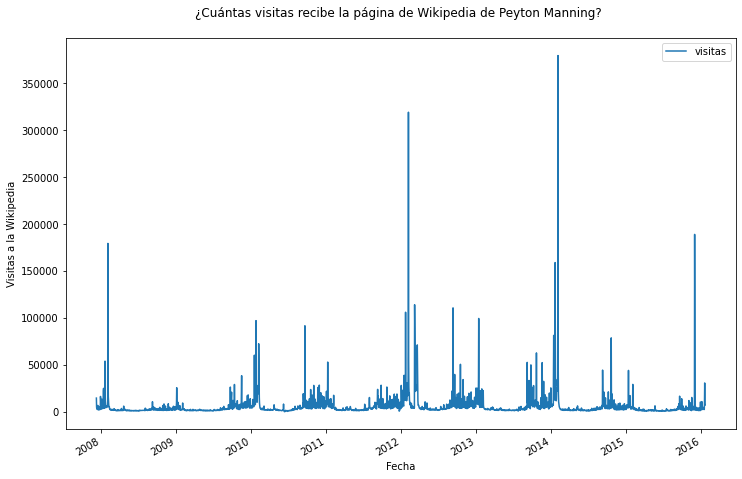

In [38]:
## Representamos nuestra serie temporal
df_datos['fecha']=pd.to_datetime(df_datos['fecha'])
ax = df_datos.set_index('fecha').plot(figsize = (12, 8),
                                      title = '¿Cuántas visitas recibe la página de Wikipedia de Peyton Manning? \n')
ax.set_ylabel('Visitas a la Wikipedia')
ax.set_xlabel('Fecha')

plt.show()

Para comprender mejor los datos que estamos viendo, puede ser interesante buscar información extra que nos ayude a entender la evolución de la serie. Utilizando las fuentes que consideres, intenta responder a las siguientes preguntas:
- ¿Cuáles han sido los hitos más importantes en la carrera de Peyton?
- ¿Se ha lesionado alguna vez?
- ¿Cómo es la liga de fútbol americano? ¿Cuál es su duración? ¿Cuándo comienza? ¿Cuándo termina?
- ¿Hay eventos o partidos especiales?
- ¿Peyton ha jugado alguno de ellos?

**P: ¿Puedes ubicar toda esta información en nuestra serie temporal?**

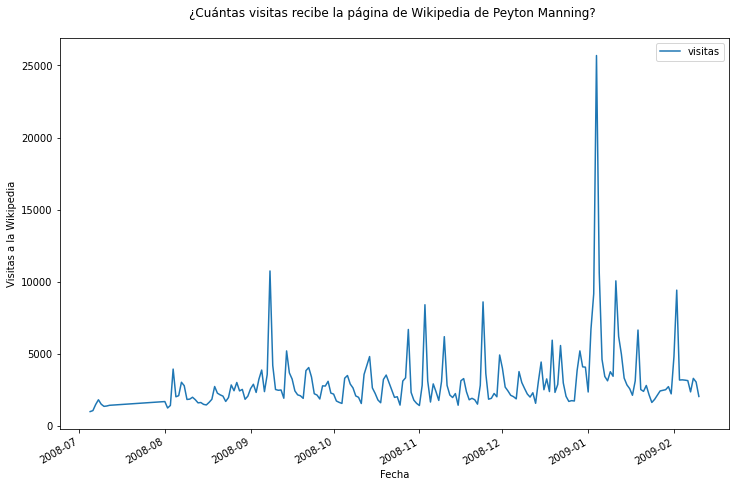

In [39]:
## Representamos nuestra serie temporal
ax = df_datos[200:400].set_index('fecha').plot(figsize = (12, 8),
                                      title = '¿Cuántas visitas recibe la página de Wikipedia de Peyton Manning? \n')
ax.set_ylabel('Visitas a la Wikipedia')
ax.set_xlabel('Fecha')

plt.show()

## 3. Preparación de los datos

En esta parte tenemos que tener mucho cuidado, ya que Prophet necesita que el DataFrame de los datos a modelizar tenga una estructura muy concreta, siguiendo unas reglas muy estrictas. Nuestro DataFrame tiene que tener dos columnas:

* **Primera Columna:** Tiene que ser una columna de **tipo fecha** y el nombre debe de ser **ds**.

* **Segunda Columna:** Tiene que ser una columna de **tipo numérica** (integer o float) y el nombre de la columna debe de ser **y**.

Si construimos un DataFrame siguiendo estas reglas Prophet será capaz de interpretar correctamente nuestros datos y generar el modelo, pero debemos ser **muy cuidadosos y seguir estas reglas al pie de la letra para evitar errores**.

Si nuestra columna fecha no ha sido interpretada y cargada por Pandas como una columna de tipo DateTime (bastante común cuando nuestro fichero tiene las fechas en formato, por ejemplo, dd/mm/yyyy, que lo suele interpretar como tipo de dato object), deberemos convertir el campo en un formato fecha.

** df['fecha']=pd.to_datetime(df['fecha'],dayfirst=True)**

In [40]:
df_datos['fecha']=pd.to_datetime(df_datos['fecha'])
df_datos.head()

,fecha,visitas
0,2007-12-10,14629
1,2007-12-11,5012
2,2007-12-12,3582
3,2007-12-13,3205
4,2007-12-14,2680


In [41]:
df_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   fecha    2905 non-null   datetime64[ns]
 1   visitas  2905 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 45.5 KB


Lo siguiente que tenemos que hacer es cambiar el nombre a nuestras columnas para nombrarlas como espera Prophet, porque...

**¿qué pasa si intentamos crear un modelo sin cambiar el nombre de las columnas a las que espera Prophet?**

In [14]:
#modelo = Prophet()
#modelo.fit(df_datos)

Tenemos que **cambiar el nombre de las columnas** a **'ds'** (fechas) y a **'y'** (datos).

In [42]:
df_datos= df_datos.rename(columns={'fecha': 'ds', 'visitas': 'y'})

In [43]:
df_datos.tail()

,ds,y
2900,2016-01-16,2483
2901,2016-01-17,10656
2902,2016-01-18,30754
2903,2016-01-19,9190
2904,2016-01-20,7269


Por último, vamos a realizar una ** transformación logarítmica** de los datos ya que creemos que nuestra variable de visitas sigue un modelo multiplicativo y como Prophet hace los cálculos estimando un modelo aditivo, es conveniente convertir nuestro modelo multiplicativo en uno aditivo aplicando simplemente logaritmos.

In [44]:
df_datos['y']=np.log(df_datos['y'])

In [45]:
df_datos.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


Si representamos de nuestro nuestro dataframe:

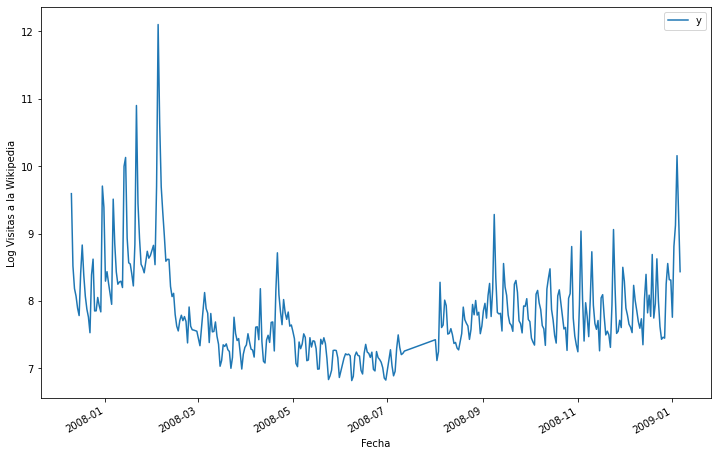

In [46]:
## Representamos nuestra serie
ax = df_datos[:365].set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Log Visitas a la Wikipedia')
ax.set_xlabel('Fecha')
plt.show()

## 4. Ajuste del modelo

Vamos a ajustar el modelo creando una instancia de un nuevo objeto Prophet. Toda la configuración del procedimiento la pasaremos en el constructor de nuestra instancia. 

Por ahora, crearemos nuestra instancia con los parámetros por defecto de Prophet.

In [47]:
modelo = Prophet()

Para ajustar nuestro modelo llamaremos al método **fit** pasándole nuestro DataFrame con los datos históricos. El cálculo del modelo es muy rápido y suele tardar entre 1 y 5 segundos.

In [48]:
modelo.fit(df_datos)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## 5. Realizar Previsiones

Para realizar nuestras previsiones, lo primero que vamos a hacer es crear un nuevo DataFrame ampliando los datos a nuevas fechas, pues queremos hacer una previsión de las visitas del año siguiente en la página web. 

Para ello, utilizamos el método **make_future_dataframe**, indicando el número de periodos de nuestra previsión (en este caso 365 días). Por defecto, nuestro DataFrame incluirá también las fechas del histórico + fechas de previsión (lo que nos permitirá luego revisar el ajuste de nuestro modelo).

In [80]:
futuro = modelo.make_future_dataframe(periods=400)

In [81]:
futuro.tail()

,ds
3300,2017-02-19
3301,2017-02-20
3302,2017-02-21
3303,2017-02-22
3304,2017-02-23


Para realizar las previsiones utilizaremos el método **predict** pasando las fechas en la que queremos hacer las previsiones. 

Como resultado vamos a obtener un DataFrame que incluirá las previsiones del modelo (columna **yhat**) así como todas los componentes de la serie (tendencia, estacionalidad, días especiales, etc.) y sus correspondientes intervalos de confianza.

In [82]:
prevision = modelo.predict(futuro)

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


In [25]:
prevision.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3265,2017-01-15,7.190114,7.527971,8.932278,6.840303,7.535542,1.018057,1.018057,1.018057,0.048303,0.048303,0.048303,0.969754,0.969754,0.969754,0.0,0.0,0.0,8.208171
3266,2017-01-16,7.189089,7.786931,9.236651,6.837595,7.535673,1.344069,1.344069,1.344069,0.352286,0.352286,0.352286,0.991783,0.991783,0.991783,0.0,0.0,0.0,8.533159
3267,2017-01-17,7.188065,7.619451,8.958661,6.835078,7.536885,1.132484,1.132484,1.132484,0.119615,0.119615,0.119615,1.012869,1.012869,1.012869,0.0,0.0,0.0,8.320549
3268,2017-01-18,7.187041,7.363577,8.852261,6.833611,7.538513,0.966144,0.966144,0.966144,-0.066665,-0.066665,-0.066665,1.032809,1.032809,1.032809,0.0,0.0,0.0,8.153184
3269,2017-01-19,7.186016,7.446964,8.910643,6.832143,7.540141,0.979089,0.979089,0.979089,-0.072267,-0.072267,-0.072267,1.051357,1.051357,1.051357,0.0,0.0,0.0,8.165106


## 6. Revisar ajuste del modelo y previsiones

La forma más sencilla de revisar el ajuste de nuestro modelo y nuestras previsiones es dibujando un gráfico. 

Prophet nos proporciona el método **plot** que automáticamente nos dibuja un gráfico configurado para que la revisión del ajuste del modelo y la previsión se pueda realizar de una forma rápida e intuitiva.

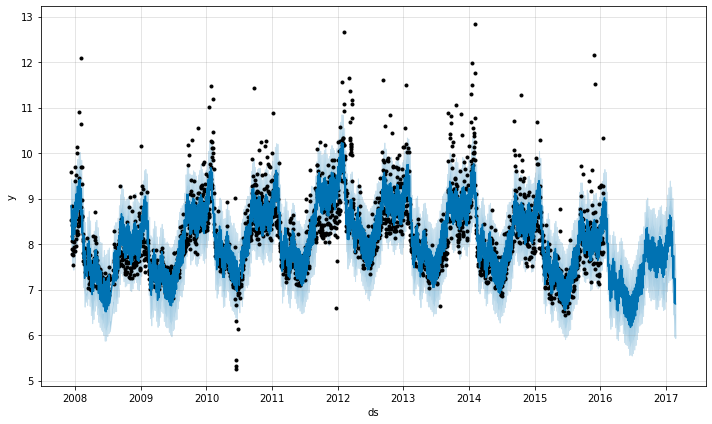

In [83]:
modelo.plot(prevision);# yhat azul oscuro , intervalos de confianza azul claro

Además, si queremos revisar los componentes calculados por nuestro modelo disponemos de otro método **plot_components** que por defecto nos permite obtener la tendencia, estacionalidad en el año, estacionalidad en la semana, ....

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


AttributeError: 'DatetimeIndex' object has no attribute 'weekday_name'

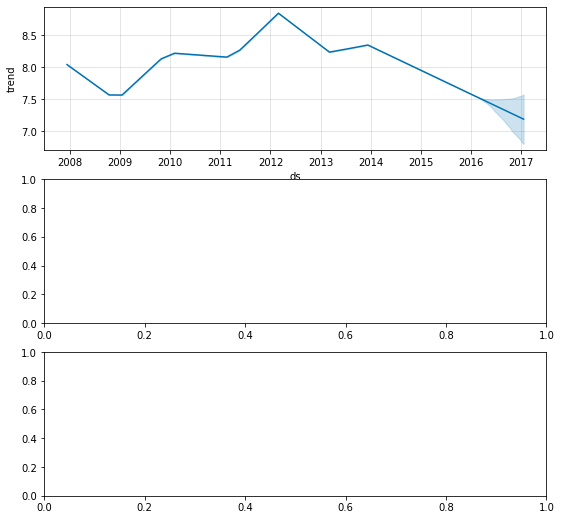

In [54]:
modelo.plot_components(prevision, weekly_start = 1);

**P: ¿Qué os parecen las previsiones?**

Vamos a mejorar las previsiones introduciendo un efecto que no estaba incluido en nuestro modelo inicial, los momentos en los que Peyton jugaba un partido de playoff o jugaba en la Superbowl, ya que seguro que afecta a las visitas de su página en Wikipedia.

In [87]:
#http://www.nfl.com/schedules/2016/POST
#  '2017-02-05'
# '2017-01-22','2017-01-14'

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07','2017-01-22','2017-01-14']),
  'lower_window': 0,
  'upper_window': 1, # Como ventanas de efecto (i.e van a tener efecto ese dia y el siguiente)
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07','2017-02-05']),
  'lower_window': 0,
  'upper_window': 1,
})


In [88]:
playoffs

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


In [89]:
superbowls

,holiday,ds,lower_window,upper_window
0,superbowl,2010-02-07,0,1
1,superbowl,2014-02-02,0,1
2,superbowl,2016-02-07,0,1
3,superbowl,2017-02-05,0,1


Vamos a unir estos dos DataFrames en uno solo, porque Prophet sólo nos deja incluir un único DataFrame con los días especiales.

In [90]:
dias_especiales = pd.concat((playoffs, superbowls))

Para que podamos introducir el efecto de estos días en nuestro modelo, Prophet vuelve a ser muy especial, tenemos que incluir la información de esos días especiales en un DataFrame que tiene una columna **ds** con las fechas, una columna **holiday** con el tipo de evento especial y dos columnas (opcionales) **lower_window** y **upper_window** que nos permite estirar el efecto de nuestros días especiales a los días anteriores (lower_window) o posteriores (upper_window). 

En este caso, decidimos que el efecto de que Peyton juegue los playoffs o la superbowl en las visitas de su página de Wikipedia se extiende al día siguiente (upper_window =1).

In [91]:
dias_especiales

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


Para incluir este DataFrame **dias_especiales** en el cálculo de nuestro modelo, simplemente le pasamos como valor del parámetro **holidays** el nombre de nuestro DataFrame al crear la instancia del modelo Prophet.

In [92]:
## https://github.com/facebook/prophet/issues/821
dias_especiales = dias_especiales.reset_index()  # THE FIX
modelo2 = Prophet(holidays=dias_especiales)
prevision2 = modelo2.fit(df_datos).predict(futuro)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Si graficamos el resultado de nuestro modelo podemos ver, como hemos explicado, varios datos atípicos en nuestras previsiones que en el anterior modelo no se explicaban.

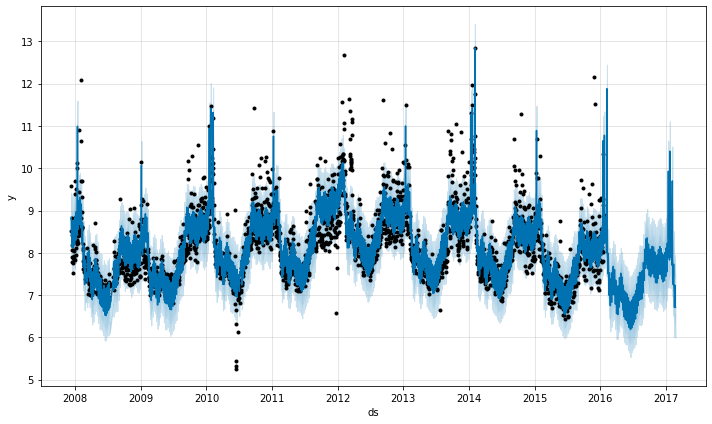

In [93]:
modelo2.plot(prevision2);

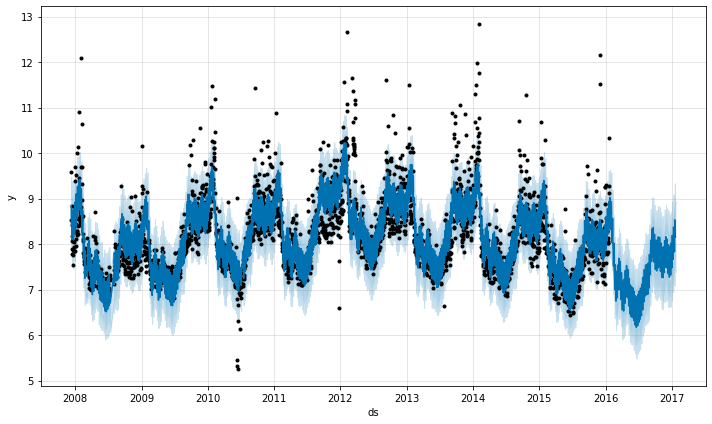

In [62]:
# Modelo anterior
modelo.plot(prevision);

El efecto en el modelo, lo podemos ver en el dataFrame de previsión, seleccionando aquellas filas en las que en las columnas superbowl y playoff tengan un valor mayor que 0.

In [76]:
prevision2[prevision2['superbowl']>0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
750,2010-02-07,8.190014,10.701935,11.951525,8.190014,8.190014,3.131574,3.131574,3.131574,2.427324,...,0.016569,0.016569,0.016569,0.687682,0.687682,0.687682,0.0,0.0,0.0,11.321589
2190,2014-02-02,8.263896,11.057580,12.249060,8.263896,8.263896,3.373370,3.373370,3.373370,2.427324,...,0.016569,0.016569,0.016569,0.929477,0.929477,0.929477,0.0,0.0,0.0,11.637266
2191,2014-02-03,8.262909,12.256533,13.437650,8.262909,8.262909,4.581884,4.581884,4.581884,3.358835,...,0.329686,0.329686,0.329686,0.893364,0.893364,0.893364,0.0,0.0,0.0,12.844794
2922,2016-02-07,7.538255,10.131328,11.300891,7.538255,7.538255,3.162252,3.162252,3.162252,2.427324,...,0.016569,0.016569,0.016569,0.718359,0.718359,0.718359,0.0,0.0,0.0,10.700507
2923,2016-02-08,7.537268,11.280570,12.463169,7.537268,7.537268,4.344278,4.344278,4.344278,3.358835,...,0.329686,0.329686,0.329686,0.655757,0.655757,0.655757,0.0,0.0,0.0,11.881545


In [77]:
prevision2[(prevision2['playoff'] + prevision2['superbowl']) > 0][
        ['ds', 'playoff', 'superbowl']]

,ds,playoff,superbowl
34,2008-01-13,1.224221,0.000000
35,2008-01-14,1.898940,0.000000
361,2009-01-03,1.224221,0.000000
362,2009-01-04,1.898940,0.000000
730,2010-01-16,1.224221,0.000000
731,2010-01-17,1.898940,0.000000
737,2010-01-25,1.898940,0.000000
750,2010-02-07,1.224221,1.203104
1076,2011-01-08,1.224221,0.000000
1077,2011-01-09,1.898940,0.000000


También podemos ver el efecto de nuestros días especiales graficando los componentes de nuestro modelos.

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


AttributeError: 'DatetimeIndex' object has no attribute 'weekday_name'

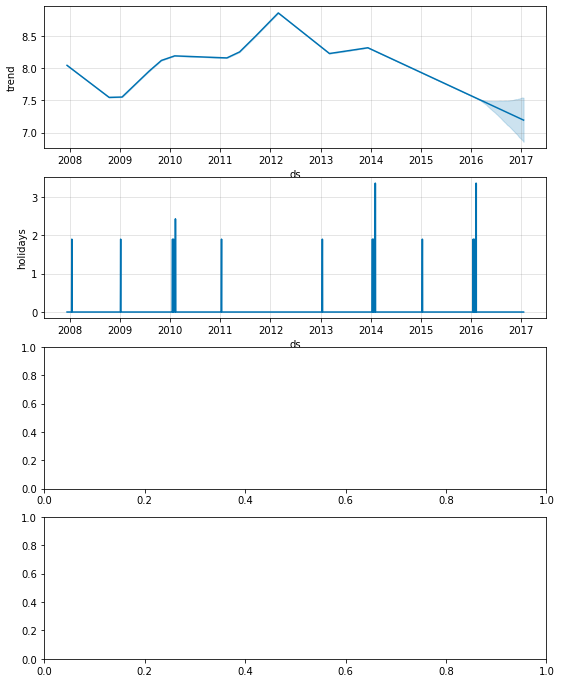

In [78]:
modelo2.plot_components(prevision2, weekly_start=1);

**P: ¿Se os ocurre cómo podríamos mejorar nuestro modelo?**

## Otro caso práctico: Ventas en retail

In [63]:
pd.plotting.register_matplotlib_converters()

In [64]:
ventas_df = pd.read_csv('retail_sales.csv')

In [65]:
ventas_df.head()

,date,sales
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


In [66]:
ventas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    72 non-null     object
 1   sales   72 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


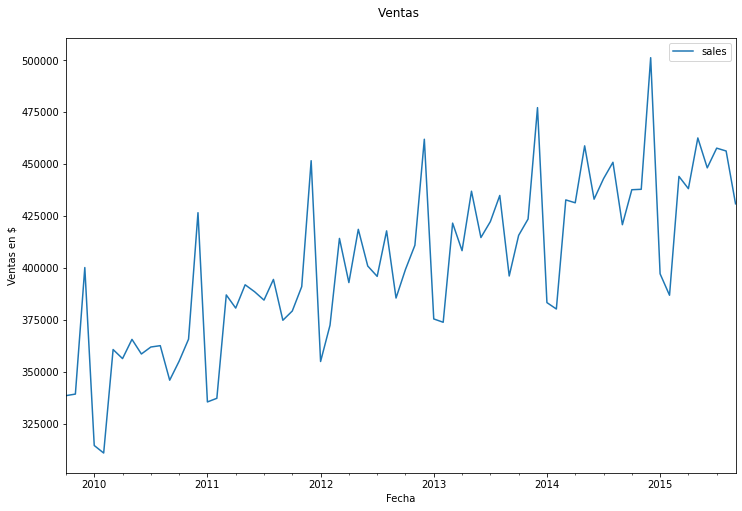

In [67]:
## Representamos nuestra serie temporal
ventas_df['date']=pd.to_datetime(ventas_df['date'])
ax = ventas_df.set_index('date').plot(figsize = (12, 8),
                                      title = 'Ventas \n')
ax.set_ylabel('Ventas en $')
ax.set_xlabel('Fecha')

plt.show()

In [68]:
ventas_df=ventas_df.rename(columns={'date': 'ds', 'sales': 'y'})

In [69]:
ventas_df.head()

,ds,y
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


In [70]:
#ventas_df.set_index('ds').y.plot()
modelo3 = Prophet()
modelo3.fit(ventas_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [71]:
futuro3 = modelo3.make_future_dataframe(periods=24, freq='m')

In [72]:
futuro3.tail()

,ds
91,2017-04-30
92,2017-05-31
93,2017-06-30
94,2017-07-31
95,2017-08-31


In [73]:
prevision3 = modelo3.predict(futuro3)

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


In [74]:
prevision3.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
91,2017-04-30,473185.536384,476811.586062,488472.192461,471267.612892,475073.541338,9544.184421,9544.184421,9544.184421,9544.184421,9544.184421,9544.184421,0.0,0.0,0.0,482729.720805
92,2017-05-31,474338.987878,472650.508385,484254.714499,472240.528830,476358.179173,4128.660788,4128.660788,4128.660788,4128.660788,4128.660788,4128.660788,0.0,0.0,0.0,478467.648666
93,2017-06-30,475455.231259,479914.339628,492230.444388,473197.052235,477624.883808,10584.585973,10584.585973,10584.585973,10584.585973,10584.585973,10584.585973,0.0,0.0,0.0,486039.817232
94,2017-07-31,476608.682753,469755.893812,482481.900115,474245.701272,478885.903275,-410.863529,-410.863529,-410.863529,-410.863529,-410.863529,-410.863529,0.0,0.0,0.0,476197.819224
95,2017-08-31,477762.134248,457681.386387,470105.998236,475284.971167,480210.081125,-14234.252935,-14234.252935,-14234.252935,-14234.252935,-14234.252935,-14234.252935,0.0,0.0,0.0,463527.881313


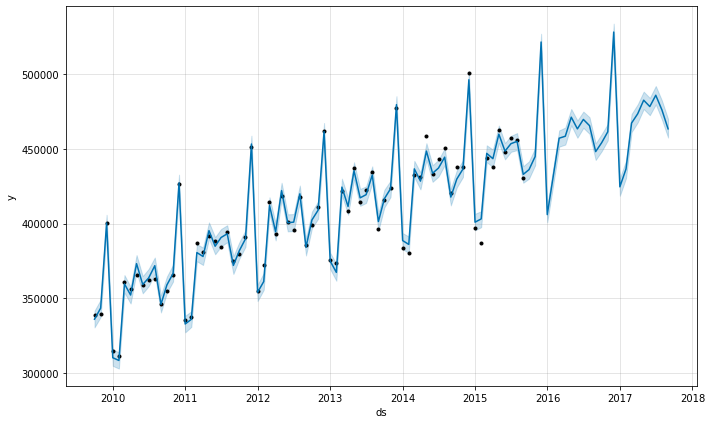

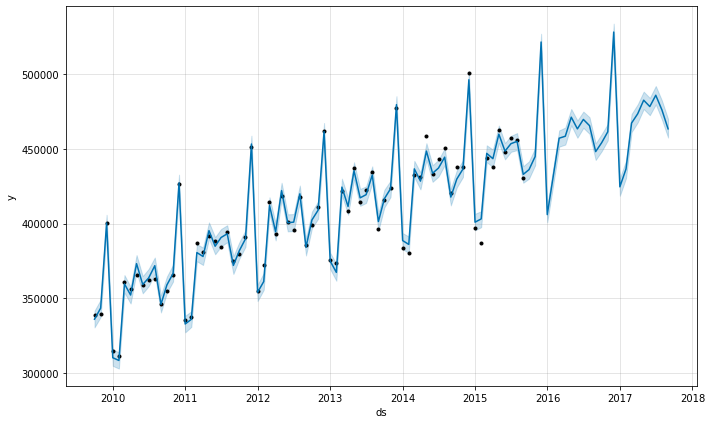

In [75]:
modelo3.plot(prevision3)

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


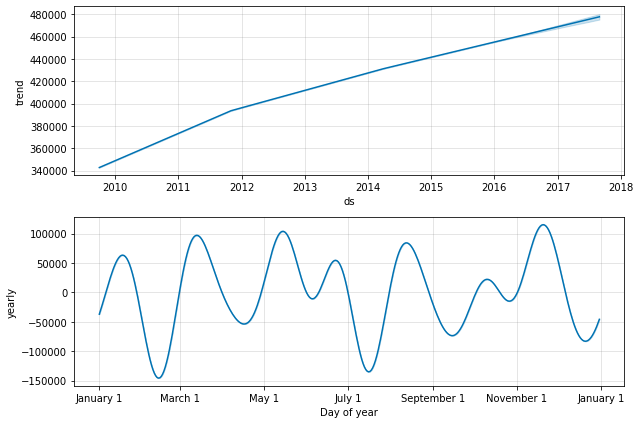

In [79]:
modelo3.plot_components(prevision3);